# script 1: Collect Samples
This tool converts a folder of samples to a big rectangular matrix with one mono sample per row.

Samples should be placed in `data/mydataset/samples/`. They could be `.mp3`, `.wav`, or anything else that ffmpeg can work with. They may be all in one folder, or in nested sub-folders.

Change the path below to point to the root directory, e.g., `data/mydataset/`.

The samplerate `sr` is not necessarily the native samplerate of the samples, it's the samplerate you want to load them at.

The output of this notebook is:
* `data/mydataset/durations.txt`
* `data/mydataset/filenames.txt`
* `data/mydataset/samples.npy`

In [1]:
data_root = "/Users/skabbit/Projects/chosician/data_sets/short stones/"
idm_root = '/Users/skabbit/Projects/chosician/builds/new/aiexperiments-drum-machine/'

sr = 44100
max_length = sr*4 # ignore samples longer than 4 seconds
seg_time = 250 # ms (default was 250)
fixed_length = sr * seg_time / 1000
# fixed_length = sr/4 # trim all samples to 250 milliseconds

limit = None # set this to 100 to only load the first 100 samples, and None to load all samples if all works good.

In [2]:
import numpy as np
from os.path import join
from utils import *
from multiprocessing import Pool

In [3]:
files = list(list_all_files(join(data_root), ['.wav']))[:limit]
len(files)

787

In [4]:
import os
def load_sample(fn, sr=None,
                max_length=None, fixed_length=None, normalize=True):
    if fn == '': # ignore empty filenames
        return None
    if not os.path.exists(fn):
        print('no file' + fn)
        return None
    audio, _ = ffmpeg_load_audio(fn, sr, mono=True)
    duration = len(audio)

    if duration == 0: # ignore zero-length samples
        return None
    if max_length and duration >= max_length: # ignore long samples
        return None 
    if fixed_length:
        audio.resize(fixed_length)
    max_val = np.abs(audio).max()
    if max_val == 0: # ignore completely silent sounds
        return None
    if normalize:
        audio /= max_val
    return (fn, audio, duration)

In [5]:
# results = []
# for fn in files:
#     results.append(load_sample(fn, sr=sr, max_length=max_length, fixed_length=fixed_length))

def job(fn):
    return load_sample(fn, sr=sr,
                       max_length=max_length, fixed_length=fixed_length)

pool = Pool()
results = pool.map(job, files[:limit])
print('Processed', len(results), 'samples')

('Processed', 787, 'samples')


In [6]:
valid = filter(None, results)
filenames = [x[0] for x in valid]
samples = [x[1] for x in valid]
durations = [x[2] for x in valid]
samples = np.asarray(samples)
np.savetxt(join(data_root, 'filenames.txt'), map(lambda x: x.rsplit('/')[-1], filenames), fmt='%s')
np.savetxt(join(data_root, 'durations.txt'), durations, fmt='%i')
np.save(join(data_root, 'samples.npy'), samples)
print('Saved', len(valid), 'samples')

('Saved', 786, 'samples')


# script 2: Samples to Fingerprints
This notebook converts `samples.npy` to `fingerprints.npy`. After processing, check the max and mean images to make sure that you are not over- or under-cropping the data. Set `crop_rows` or `crop_cols` to `None` to see all the data.

In [7]:
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

In [8]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa

/Users/skabbit/Projects/chosician/.conda/lib/python2.7/site-packages/librosa/__init__.py:35: FutureWarning: You are using librosa with Python 2. Please note that librosa 0.7 will be the last version to support Python 2, after which it will require Python 3 or later.
  FutureWarning)


In [9]:
# %time samples = np.load(join(data_root, 'samples.npy'))

In [10]:
window = np.hanning(n_fft)
def job(y):
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
    amp = np.abs(S)
    if reduce_rows > 1 or reduce_cols > 1:
        amp = block_reduce(amp, (reduce_rows, reduce_cols), func=np.mean)
    if amp.shape[1] < crop_cols:
        amp = np.pad(amp, ((0, 0), (0, crop_cols-amp.shape[1])), 'constant')
    amp = amp[:crop_rows, :crop_cols]
    if use_logamp:
        amp = librosa.logamplitude(amp**2)
    amp -= amp.min()
    if amp.max() > 0:
        amp /= amp.max()
    amp = np.flipud(amp) # for visualization, put low frequencies on bottom
    return amp
pool = Pool()
fingerprints = pool.map(job, samples[:limit])
fingerprints = np.asarray(fingerprints).astype(np.float32)

In [11]:
np.save(join(data_root, 'fingerprints.npy'), fingerprints)

('data shape:', (786, 32, 32))
mean:


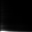

max:


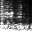

random selection:


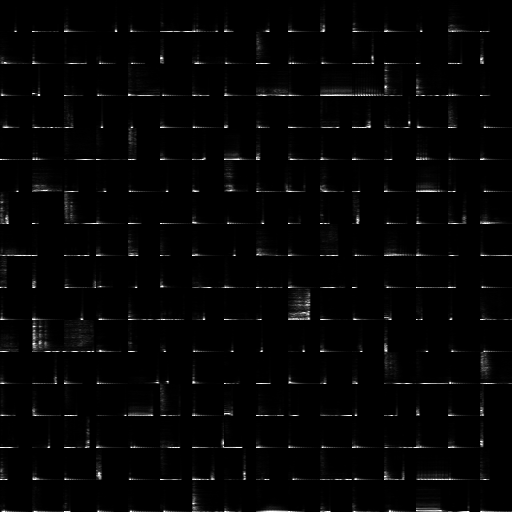

In [12]:
print('data shape:', np.shape(fingerprints))

mean = np.mean(fingerprints, axis=0)
mean -= mean.min()
mean /= mean.max()

print('mean:')
show_array(255 * mean)
print('max:')
show_array(255 * np.max(fingerprints, axis=0))

print('random selection:')
indices = range(len(fingerprints))
np.random.shuffle(indices)
show_array(255 * make_mosaic(np.array(fingerprints)[indices], n=16))

# script 3: Fingerprints to t-SNE
This converts `fingerprints.npy` to `.tsv` formatted t-SNE embeddings and plots of those embeddings in the `tsne/` and `plot/` folders respectively. If you add multiple values to `perplexity` and `initial_dims` then all combinations will be computed (in parallel). Good perplexities are in the range 1-200 with the best range around 30-100. Good `initial_dims` are in the range 30 and higher, with the dimensionality of your input data being the highest possible value (e.g., a 32x32 fingerprint would have a highest possible `initial_dims` value of 32x32=1024).

Change the "mode" to try different t-SNE variations.
* "fingerprints" will only use `fingerprints.npy`
* "predicted_labels" will only use `predicted_labels.npy`
* "predicted_encoding" will only use `predicted_encoding.npy`
* "combined" will use all of the above data

In [13]:
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
# mode = 'predicted_labels'
# mode = 'predicted_encoding'
# mode = 'combined'

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from time import time
from utils import *
from os.path import join
from multiprocessing import Pool
import numpy as np
import itertools

In [15]:
def save_tsv(data, fn):
    np.savetxt(fn, data, fmt='%.5f', delimiter='\t')
def tsne(data, data_root, prefix, initial_dims=30, perplexity=30):
    mkdir_p(data_root + 'tsne')
    mkdir_p(data_root + 'plot')
    
    figsize = (16,16)
    pointsize = 2

    X_2d = list(bh_tsne(data, initial_dims=initial_dims, perplexity=perplexity, no_dims=2))
    X_2d = normalize(np.array(X_2d))
    save_tsv(X_2d, join(data_root, 'tsne/{}.{}.{}.2d.tsv'.format(prefix, initial_dims, perplexity)))
    
    plt.figure(figsize=figsize)
    plt.scatter(X_2d[:,0], X_2d[:,1], edgecolor='', s=pointsize)
    plt.tight_layout()
    plt.savefig(join(data_root, 'plot/{}.{}.{}.png'.format(prefix, initial_dims, perplexity)))
    plt.close()
    
    X_3d = list(bh_tsne(data, initial_dims=initial_dims, perplexity=perplexity, no_dims=3))
    X_3d = normalize(np.array(X_3d))
    save_tsv(X_3d, join(data_root, 'tsne/{}.{}.{}.3d.tsv'.format(prefix, initial_dims, perplexity)))
    
    plt.figure(figsize=figsize)
    plt.scatter(X_2d[:,0], X_2d[:,1], edgecolor='', s=pointsize, c=X_3d)
    plt.tight_layout()
    plt.savefig(join(data_root, 'plot/{}.{}.{}.png'.format(prefix, initial_dims, perplexity)))
    plt.close()

In [16]:
# load and normalize any dataset we need
if mode == 'fingerprints' or mode == 'combined':
    fingerprints = np.load(join(data_root, 'fingerprints.npy'))
    fingerprints = fingerprints.reshape(len(fingerprints), -1)
if mode == 'predicted_labels' or mode == 'combined':
    predicted_labels = np.load(join(data_root, 'predicted_labels.npy'))
    predicted_labels -= predicted_labels.min()
    predicted_labels /= predicted_labels.max()
if mode == 'predicted_encoding' or mode == 'combined':
    predicted_encoding = np.load(join(data_root, 'predicted_encoding.npy'))
    std = predicted_encoding.std(axis=0)
    predicted_encoding = predicted_encoding[:, std > 0] / std[std > 0]
    
if mode == 'fingerprints':
    data = fingerprints
if mode == 'predicted_labels':
    data = predicted_labels
if mode == 'predicted_encoding':
    data = predicted_encoding
if mode == 'combined':
    data = np.hstack((fingerprints, predicted_labels, predicted_encoding))
    
print(data.shape)

(786, 1024)


In [ ]:
data = data.astype(np.float64)
def job(params):
    start = time()
    tsne(data, data_root, mode, initial_dims=params[0], perplexity=params[1])
    print 'initial_dims={}, perplexity={}, {} seconds'.format(params[0], params[1], time() - start)
params = list(itertools.product(initial_dims, perplexities))
pool = Pool()
pool.map(job, params)

utils/bhtsne.py:129: ComplexWarning: Casting complex values to real discards the imaginary part
  data_file.write(pack('{}d'.format(len(sample)), *sample))


# script 4: Samples to Audio Spritesheet

In [ ]:
total_limit = None # set this to 100 to export 100 samples
length_limit = fixed_length # set this to sr/4 to only export 250ms of audio per sample

from os.path import join
from utils import ffmpeg_save_audio

In [ ]:
# %time samples = np.load(join(data_root, 'samples.npy'))

In [ ]:
y = samples[:total_limit, :length_limit].reshape(-1)
%time ffmpeg_save_audio(data_root + 'spritesheet.mp3', y, sr)

# script 5: create analysis.tsv

In [ ]:
# Copyright 2016 Google Inc.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import librosa
import numpy
import traceback
from multiprocessing import Pool

sample_rate = 44100

    
def scale(arr):
    # get the average
    avg = numpy.average(arr)
    # scale from 20,20000 to 0,1
    return (avg - 20) / (20000 - 20)


def analyse(file):
    y, sr = librosa.load(file, sr=sample_rate, duration=0.25)
    centroid = scale(librosa.feature.spectral_centroid(y=y, sr=sr))
    bandwidth = scale(librosa.feature.spectral_bandwidth(y=y, sr=sr)) 
    # rolloff = scale(librosa.feature.spectral_rolloff(y=y, sr=sr))   
    # contrast = scale(librosa.feature.spectral_contrast(y=y, sr=sr))   
    return numpy.asarray([centroid, bandwidth])

kick_values = analyse("../ref_sounds/Kick.wav")
snare_values = analyse("../ref_sounds/Snare.wav")
hihat_values = analyse("../ref_sounds/OpenHihat.wav")
open_values = analyse("../ref_sounds/Closed.wav")


def get_distance(test_values):
    test_values = numpy.asarray(test_values)
    kick_dist = numpy.linalg.norm(test_values - kick_values)
    snare_dist = numpy.linalg.norm(test_values - snare_values)
    hihat_dist = numpy.linalg.norm(test_values - hihat_values)
    open_dist = numpy.linalg.norm(test_values - open_values)
    return [kick_dist, snare_dist, hihat_dist, open_dist]

# print get_distance(snare_values)

def process(file_name):
    try:
        return get_distance(analyse(data_root + file_name))
    except Exception as e:
        print('%s: %s' % (file_name, traceback.format_exc()))
        raise e

if __name__ == "__main__":
    with open(data_root + "./filenames.txt") as file_names:
        files = file_names.read().splitlines() 

        results = []
        for f in files:
            results += [process(f)]

        print "Done", len(results)
        numpy.savetxt(data_root + "analysis.tsv", results, delimiter="\t", fmt="%.6f")

# script 6: split samples (from utils/split.py)

In [ ]:
# Copyright 2016 Google Inc.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



from pydub import AudioSegment
import json
import os
import numpy
import math
import re
import sys
# from AudioNotebooks import config

if not os.path.exists(idm_root + "meta/"):
    print(idm_root + "meta/")
    os.makedirs(idm_root + "meta/")
if not os.path.exists(idm_root + "audio/"):
    os.makedirs(idm_root + "audio/")

sounds = AudioSegment.from_file(data_root + "spritesheet.mp3", format="mp3")

print "len(sounds) = ", len(sounds)
print "samples count apprx. = ", int(len(sounds) / 250)

with open(data_root + 'filenames.txt') as file_name_file:
    file_names = file_name_file.read().split("\n")[:-1]

# seg_time = config.chunk_ms
# seg_time = 250

num_samples = len(file_names)
num_of_top_tags = 50


# num_chunks = config.chunks
num_chunks = 30
min_split_size = 30

print(num_samples)


# generate a distribution whose sum is the total number of samples
for i in range(1000000):
    distribution = numpy.logspace(math.log(min_split_size, 10.0), math.log(min_split_size + i, 10.0), num=num_chunks, base=10.0, endpoint=True, dtype=int)
    if sum(distribution) >= num_samples:
        diff = sum(distribution) - num_samples
        # subtract the diference from the last one
        print "diff =", diff
        distribution[-1] -= diff
        break

print(sum(distribution))
print(len(distribution))
print distribution

# sys.exit()

def combine_json(data_file_names, data_tags, data_coords, data_colors, data_analyses):
    meta_data = []
    all_tags = []
    all_tally = []
    tag_list = []
    for index in range(len(data_file_names)):
        # tag_list = data_tags[index].split()
        # tag_list = [i.upper() for i in tag_list]
        coord = data_coords[index].split()
        coord = [float(i) for i in coord]
        color = data_colors[index].split()
        color = [float(i) for i in color]
        analysis = data_analyses[index].split()
        analysis = [float(i) for i in analysis]
        meta_data.append({
            # "tags" : tag_list,
            "color" : color,
            "coords" : coord,
            "analysis" : analysis,
#             "pitch" : samples_pitches[index],
            "name" : data_file_names[index],
        })
        # add the tags to the list
    #     for j in range(0, len(tag_list)):
    #         tag = tag_list[j].upper()
    #         if tag not in all_tags:
    #             all_tags.append(tag)
    #             all_tally.append(1)
    #         else:
    #             index = all_tags.index(tag)
    #             all_tally[index]+=1

    # ordered_index_list = sorted(range(len(all_tally)), key=lambda x: all_tally[x])
    # ordered_index_list = ordered_index_list[-num_of_top_tags:]
    # ordered_index_list = ordered_index_list[::-1]
    autosuggest_list = []

    # for k in range(0, len(ordered_index_list)):
    #     index = ordered_index_list[k]
    #     tag_dict = {}
    #     tag_dict[all_tags[index]] = all_tally[index]
    #     autosuggest_list.append(tag_dict)

    print("count: ", len(meta_data))
    return {
        "autoSuggest" : autosuggest_list,
        "metaData" : meta_data
    }

# the coordinates
with open(data_root + 'tsne/fingerprints.30.30.2d.tsv') as data_file:
    coords = data_file.read().split("\n")

with open(data_root + 'tsne/fingerprints.30.30.3d.tsv') as data_file:
    colors = data_file.read().split("\n")

with open(data_root + 'analysis.tsv') as data_file:
    analyses = data_file.read().split("\n")

# BUG: https://github.com/googlecreativelab/aiexperiments-drum-machine/issues/10
# with open('data/tags.tsv') as tag_file:
#     tags = tag_file.read().split("\n")
# with open('data/name.tsv') as name_file:
#     names = name_file.read().split("\n")

tags = [] * len(file_names)
with open(data_root + 'filenames.txt') as file_name_file:
    names = file_name_file.read().split("\n")[:-1]
    names = map(lambda x: x.split("/")[-1], names)

seg_start = 0

for s in range(0, len(distribution)):
# for s in range(0, 2):
    print "chunk : ", s

    file_name = file_names[seg_start : (seg_start + distribution[s])]
    # the tag data
    tag = tags[seg_start : (seg_start + distribution[s])]
    # the coordinates
    coord = coords[seg_start : (seg_start + distribution[s])]
    color = colors[seg_start : (seg_start + distribution[s])]
    analysis = analyses[seg_start : (seg_start + distribution[s])]
    name = names[seg_start : (seg_start + distribution[s])]

    print len(name), len(tag), len(coord), len(color), len(analysis)
    outString = combine_json(name, tag, coord, color, analysis)

    with open(idm_root + "meta/" + str(s) + ".json", 'w+') as outfile:
        json.dump(outString, outfile)

    # the audio file
    seg = sounds[seg_start * seg_time : (seg_start + distribution[s]) * seg_time ]
    print "distribution[s] = ", distribution[s]
    print "len(seg) = ", len(seg), seg_start * seg_time, (seg_start + distribution[s]) * seg_time
    seg.export(idm_root + "audio/" + str(s) + ".mp3", format="mp3")
    print idm_root + "audio/" + str(s) + ".mp3"

    seg_start += distribution[s]



# script 7: sort sounds, write drum_list.json

In [ ]:
# Copyright 2016 Google Inc.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import json

with open(data_root + "analysis.tsv") as analysis_file:
    analyses = analysis_file.read().split("\n")
    kick_like = []
    snare_like = []
    hh_like = []
    openhh_like = []
    for anl in analyses[:-1]:
        row = anl.split("\t")
        row = list(map(float, row))
        kick_like.append(row[0])
        snare_like.append(row[1])
        hh_like.append(row[2])
        openhh_like.append(row[3])

    most_kick_like = sorted(range(len(kick_like)), key=lambda k: kick_like[k])
    most_snare_like = sorted(range(len(snare_like)), key=lambda k: snare_like[k])
    most_hh_like = sorted(range(len(hh_like)), key=lambda k: hh_like[k])
    most_openhh_like = sorted(range(len(openhh_like)), key=lambda k: openhh_like[k])

    output_dict = dict()
    limit = 200
    output_dict["3"] = sorted(most_kick_like[:limit])
    output_dict["2"] = sorted(most_snare_like[:limit])
    output_dict["1"] = sorted(most_hh_like[:limit])
    output_dict["0"] = sorted(most_openhh_like[:limit])
    with open(idm_root + "meta/drum_like.json", "w") as drum_json:
        json.dump(output_dict, drum_json, indent=4)
